INITIAL EDA 

In [1]:
%pip install seaborn bs4

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
import re
from bs4 import BeautifulSoup

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.shape

(404290, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [8]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [9]:
df = df.dropna()


In [10]:
df.duplicated().sum()

0

In [11]:
print(df['is_duplicate'].value_counts())


is_duplicate
0    255024
1    149263
Name: count, dtype: int64


    HANDLING IMBALANCE

In [12]:
df_0 = df[df['is_duplicate'] == 0]
df_1 = df[df['is_duplicate'] == 1]


In [13]:
df_0_sampled = df_0.sample(
    n=len(df_1),
    random_state=42
)


In [14]:
df_balanced = pd.concat([df_0_sampled, df_1])


In [15]:
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [16]:
df['is_duplicate'].value_counts()


is_duplicate
1    149263
0    149263
Name: count, dtype: int64

In [17]:
df.shape

(298526, 6)

In [18]:
# repeated questions from q1 and q2 combined 


qid = pd.Series(df['qid1'].tolist()+ df['qid2'].tolist())
print("Number of unique questions", np.unique(qid).shape[0])
x = qid.value_counts() > 1
print('Number of questions getting repeated ',x[x].shape[0])

Number of unique questions 391054
Number of questions getting repeated  79143


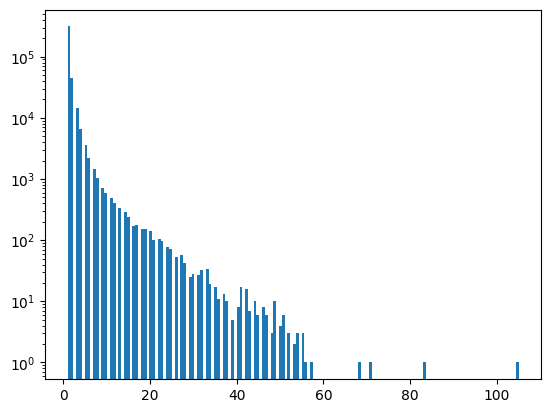

In [19]:
# histogram for repeated questions 

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

        PREPROCESSING QUESTIONS 

In [20]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [21]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

    FEATURE ENGINEERING 

In [22]:
# 1) char length of q1
# 2) char length of q2
# 3) No. of words in q1
# 4) No. of words in q2
# 5) No. of common unique words
# 6) Total No. of words from both 
# 7) word common / word total 

In [23]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [24]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
0,364720,494790,484904,why does god hate gays if he made them,if god hates homosexuality why did he make it...,1,38,55
1,221233,328525,328526,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina,1,59,47
2,121761,197246,197247,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars,0,92,45
3,249661,363349,195254,what are some things new employees should know...,what are some things new employees should know...,0,89,83
4,212447,9163,46561,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...,1,67,84


In [25]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
0,364720,494790,484904,why does god hate gays if he made them,if god hates homosexuality why did he make it...,1,38,55,9,11
1,221233,328525,328526,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina,1,59,47,13,9
2,121761,197246,197247,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars,0,92,45,14,10
3,249661,363349,195254,what are some things new employees should know...,what are some things new employees should know...,0,89,83,16,15
4,212447,9163,46561,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...,1,67,84,13,17


In [26]:
def common_words(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)


In [27]:
df['word_common'] = df.apply(common_words,axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
0,364720,494790,484904,why does god hate gays if he made them,if god hates homosexuality why did he make it...,1,38,55,9,11,4
1,221233,328525,328526,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina,1,59,47,13,9,4
2,121761,197246,197247,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars,0,92,45,14,10,3
3,249661,363349,195254,what are some things new employees should know...,what are some things new employees should know...,0,89,83,16,15,14
4,212447,9163,46561,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...,1,67,84,13,17,7


In [28]:
def total_words(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return (len(w1)+len(w2))

In [29]:
df['word_total'] = df.apply(total_words,axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
0,364720,494790,484904,why does god hate gays if he made them,if god hates homosexuality why did he make it...,1,38,55,9,11,4,20
1,221233,328525,328526,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina,1,59,47,13,9,4,22
2,121761,197246,197247,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars,0,92,45,14,10,3,22
3,249661,363349,195254,what are some things new employees should know...,what are some things new employees should know...,0,89,83,16,15,14,31
4,212447,9163,46561,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...,1,67,84,13,17,7,30


In [30]:
df['word_share']=round(df['word_common']/df['word_total'],2)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
0,364720,494790,484904,why does god hate gays if he made them,if god hates homosexuality why did he make it...,1,38,55,9,11,4,20,0.20
1,221233,328525,328526,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina,1,59,47,13,9,4,22,0.18
2,121761,197246,197247,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars,0,92,45,14,10,3,22,0.14
3,249661,363349,195254,what are some things new employees should know...,what are some things new employees should know...,0,89,83,16,15,14,31,0.45
4,212447,9163,46561,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...,1,67,84,13,17,7,30,0.23


In [31]:
df.shape

(298526, 13)

    EDA ON FEATURES 

minimum characters :  0
maximum characters :  621
Average num of characters 57


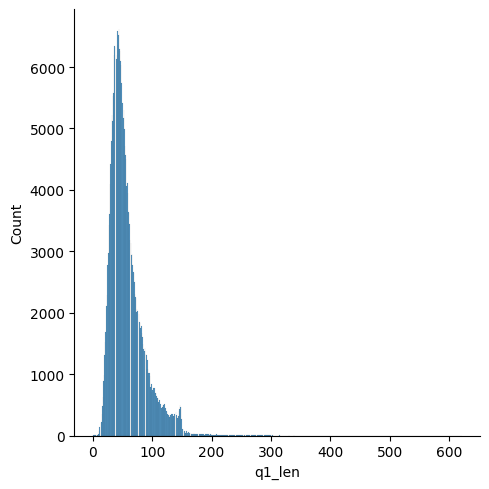

In [32]:
sns.displot(df['q1_len'])
print('minimum characters : ',df['q1_len'].min())
print('maximum characters : ',df['q1_len'].max())
print('Average num of characters',int(df['q1_len'].mean()))

minimum characters :  0
maximum characters :  1170
Average num of characters 57


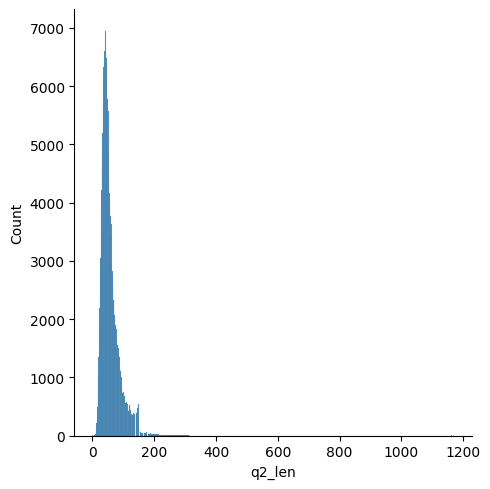

In [33]:
sns.displot(df['q2_len'])
print('minimum characters : ',df['q2_len'].min())
print('maximum characters : ',df['q2_len'].max())
print('Average num of characters',int(df['q2_len'].mean()))

minimum words :  1
maximum words :  147
Average num of words 11


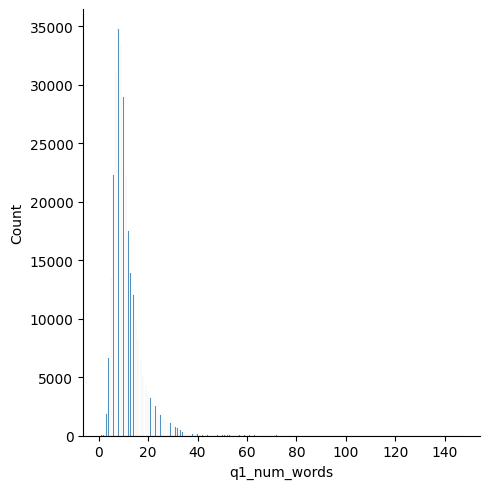

In [34]:
sns.displot(df['q1_num_words'])
print('minimum words : ',df['q1_num_words'].min())
print('maximum words : ',df['q1_num_words'].max())
print('Average num of words',int(df['q1_num_words'].mean()))

minimum words :  1
maximum words :  270
Average num of words 11


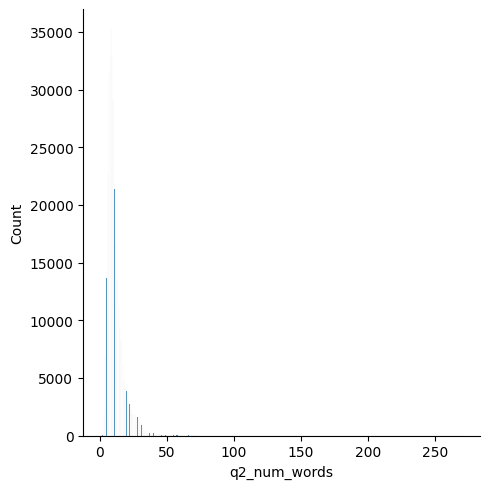

In [35]:
sns.displot(df['q2_num_words'])
print('minimum words : ',df['q2_num_words'].min())
print('maximum words : ',df['q2_num_words'].max())
print('Average num of words',int(df['q2_num_words'].mean()))

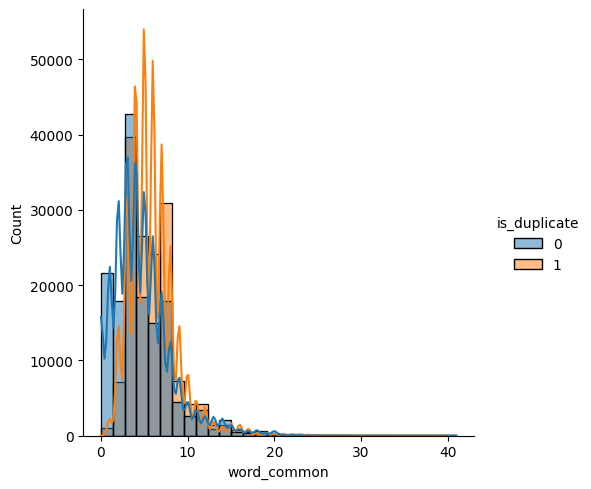

In [36]:
# common words 

sns.displot(
    data=df,
    x='word_common',
    hue='is_duplicate',
    kde=True,
    bins=30
)
plt.show()


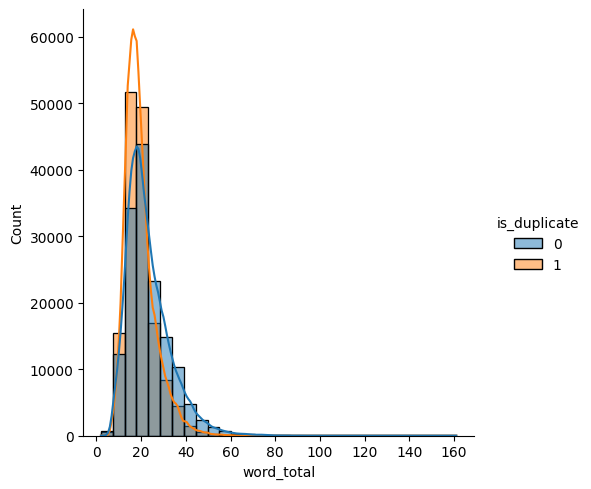

In [37]:
# total words 

sns.displot(
    data=df,
    x='word_total',
    hue='is_duplicate',
    kde=True,
    bins=30
)
plt.show()

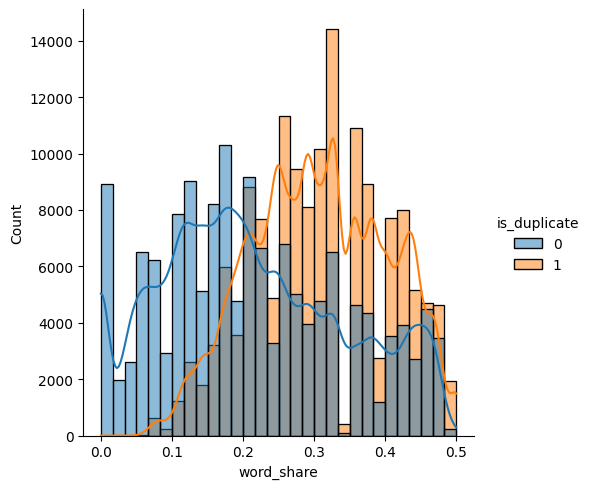

In [38]:
#  word share 

sns.displot(
    data=df,
    x='word_share',
    hue='is_duplicate',
    kde=True,
    bins=30
)
plt.show()

    ADVANCED FEATURE ENGINNERING

In [39]:
%pip install nltk distance xgboost gensim

Note: you may need to restart the kernel to use updated packages.


In [40]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [41]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\Admin-
[nltk_data]     CSE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [43]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,364720,494790,484904,why does god hate gays if he made them,if god hates homosexuality why did he make it...,1,38,55,9,11,...,20,0.20,0.249994,0.199996,0.599988,0.599988,0.444440,0.399996,0.0,0.0
1,221233,328525,328526,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina,1,59,47,13,9,...,22,0.18,0.499988,0.399992,0.399992,0.249997,0.444440,0.307690,0.0,0.0
2,121761,197246,197247,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars,0,92,45,14,10,...,22,0.14,0.249994,0.142855,0.399992,0.333328,0.299997,0.214284,0.0,1.0
3,249661,363349,195254,what are some things new employees should know...,what are some things new employees should know...,0,89,83,16,15,...,31,0.45,0.874989,0.777769,0.999986,0.999986,0.933327,0.874995,0.0,1.0
4,212447,9163,46561,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...,1,67,84,13,17,...,30,0.23,0.833319,0.499995,0.333328,0.285710,0.538457,0.437497,0.0,0.0


In [44]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    if len(strs) > 0:
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        length_features[2] = 0.0
    
    return length_features

In [45]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [46]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
0,364720,494790,484904,why does god hate gays if he made them,if god hates homosexuality why did he make it...,1,38,55,9,11,...,0.199996,0.599988,0.599988,0.444440,0.399996,0.0,0.0,1.0,9.5,0.230769
1,221233,328525,328526,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina,1,59,47,13,9,...,0.399992,0.399992,0.249997,0.444440,0.307690,0.0,0.0,4.0,11.0,0.208333
2,121761,197246,197247,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars,0,92,45,14,10,...,0.142855,0.399992,0.333328,0.299997,0.214284,0.0,1.0,4.0,12.0,0.239130
3,249661,363349,195254,what are some things new employees should know...,what are some things new employees should know...,0,89,83,16,15,...,0.777769,0.999986,0.999986,0.933327,0.874995,0.0,1.0,1.0,15.5,0.916667
4,212447,9163,46561,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...,1,67,84,13,17,...,0.499995,0.333328,0.285710,0.538457,0.437497,0.0,0.0,3.0,14.5,0.323529


In [47]:
# Fuzzy Features
%pip install fuzzywuzzy
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

Note: you may need to restart the kernel to use updated packages.


c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [48]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [49]:
print(df.shape)
df.head()

(298526, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,364720,494790,484904,why does god hate gays if he made them,if god hates homosexuality why did he make it...,1,38,55,9,11,...,0.399996,0.0,0.0,1.0,9.5,0.230769,47,43,57,57
1,221233,328525,328526,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina,1,59,47,13,9,...,0.307690,0.0,0.0,4.0,11.0,0.208333,60,66,64,64
2,121761,197246,197247,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars,0,92,45,14,10,...,0.214284,0.0,1.0,4.0,12.0,0.239130,44,53,38,51
3,249661,363349,195254,what are some things new employees should know...,what are some things new employees should know...,0,89,83,16,15,...,0.874995,0.0,1.0,1.0,15.5,0.916667,91,94,88,96
4,212447,9163,46561,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...,1,67,84,13,17,...,0.437497,0.0,0.0,3.0,14.5,0.323529,60,67,73,77


In [50]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
0,why does god hate gays if he made them,if god hates homosexuality why did he make it...
1,what happens to a photon after it hits the ret...,where does a photon go after hitting our retina
2,what are some legitimate explanations for the ...,what is the history of the ewoks in star wars
3,what are some things new employees should know...,what are some things new employees should know...
4,what are some of the best coaching institutes ...,which coaching institute is best for gmat in d...


In [51]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()
for_wtv_df = final_df

(298526, 23)


    VECTORIZATION AND MODEL

In [52]:
from joblib import load
cv = load("count_vectorizer1.joblib")


c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.7.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [53]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

# cv = CountVectorizer(max_features=3000)
q_mat = cv.fit_transform(questions)
q1_mat = q_mat[:len(ques_df)]
q2_mat = q_mat[len(ques_df):]

In [54]:
temp_df1 = pd.DataFrame.sparse.from_spmatrix(q1_mat, index=ques_df.index)
temp_df2 = pd.DataFrame.sparse.from_spmatrix(q2_mat, index=ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(298526, 6000)

In [55]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(298526, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,1,38,55,9,11,4,20,0.20,0.249994,0.199996,...,0,0,0,0,0,0,0,0,0,0
1,1,59,47,13,9,4,22,0.18,0.499988,0.399992,...,0,0,0,0,0,0,0,0,0,0
2,0,92,45,14,10,3,22,0.14,0.249994,0.142855,...,0,0,0,0,0,0,0,0,0,0
3,0,89,83,16,15,14,31,0.45,0.874989,0.777769,...,0,0,0,0,0,0,0,0,0,0
4,1,67,84,13,17,7,30,0.23,0.833319,0.499995,...,0,0,0,0,0,0,0,0,0,0


In [56]:

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [57]:
from joblib import load
rf = load("randomForest_BOW.joblib")


c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# rf = RandomForestClassifier()
# rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8213244900010049

In [59]:
from joblib import load
xgb = load("XGBClassifier_BOW.joblib")


c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\pickle.py:1718: UserWarning: [12:34:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\gbm\../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [60]:
from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.806351120490403

In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[22310,  7594],
       [ 3074, 26728]], dtype=int64)

In [63]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[21663,  8241],
       [ 3321, 26481]], dtype=int64)

In [64]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [65]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [66]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [67]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [68]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [69]:
def query_point_creator(q1,q2):
    from scipy import sparse
    input_query = []
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    # bow feature for q1 and q2 as sparse
    q1_bow = cv.transform([q1])
    q2_bow = cv.transform([q2])
    input_arr = np.array(input_query).reshape(1,-1)
    input_sparse = sparse.csr_matrix(input_arr)
    combined = sparse.hstack([input_sparse, q1_bow, q2_bow])
    return combined

In [70]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [71]:
rf.predict(query_point_creator(q2,q3))

array([0], dtype=int64)

In [72]:
xgb.predict(query_point_creator(q1,q3))

array([0])

In [73]:
cv

CountVectorizer(max_features=3000)

VECTORIZATION AND MODEL PART 2 (WORD TO VEC)

In [74]:
import gensim.downloader as api

w2v = api.load("word2vec-google-news-300")


In [75]:
import re

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z ]', '', text)
    return text.split()


In [76]:
import numpy as np

def sentence_vector(sentence, model, vector_size=300):
    words = preprocess(sentence)
    vectors = [model[word] for word in words if word in model]

    if len(vectors) == 0:
        return np.zeros(vector_size)

    return np.mean(vectors, axis=0)


In [77]:
q1_vectors = np.vstack(
    ques_df['question1'].apply(lambda x: sentence_vector(x, w2v))
)

q2_vectors = np.vstack(
    ques_df['question2'].apply(lambda x: sentence_vector(x, w2v))
)


In [78]:
q1_df = pd.DataFrame(q1_vectors, index=ques_df.index)
q2_df = pd.DataFrame(q2_vectors, index=ques_df.index)

final_df_wtv = pd.concat([for_wtv_df, q1_df, q2_df], axis=1)


In [79]:
final_df_wtv.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,290,291,292,293,294,295,296,297,298,299
0,1,38,55,9,11,4,20,0.20,0.249994,0.199996,...,-0.063159,0.030811,-0.170148,0.027930,-0.115430,0.062646,0.063913,-0.069263,0.070587,-0.039233
1,1,59,47,13,9,4,22,0.18,0.499988,0.399992,...,-0.051651,0.107616,-0.072418,-0.032646,-0.008972,0.148392,-0.062531,-0.073872,0.133224,-0.002869
2,0,92,45,14,10,3,22,0.14,0.249994,0.142855,...,-0.076172,-0.055325,-0.032860,0.067642,-0.006493,-0.067825,-0.045151,-0.031036,0.063087,-0.012291
3,0,89,83,16,15,14,31,0.45,0.874989,0.777769,...,-0.048964,0.018472,-0.091091,0.009862,-0.046890,0.025081,0.050315,-0.004861,0.037755,-0.051261
4,1,67,84,13,17,7,30,0.23,0.833319,0.499995,...,-0.092506,0.070501,-0.114075,0.010152,0.039581,0.000152,-0.013774,-0.026774,-0.053446,0.036352


In [80]:
final_df_wtv.shape

(298526, 623)

In [81]:

from sklearn.model_selection import train_test_split
X_train_wtv,X_test_wtv,y_train_wtv,y_test_wtv = train_test_split(final_df_wtv.iloc[:,1:].values,final_df_wtv.iloc[:,0].values,test_size=0.2,random_state=1)

In [82]:
from joblib import load
rf = load("RandomForestClassifier_WTV.joblib")

c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.7.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.7.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# rf = RandomForestClassifier()
# rf.fit(X_train_wtv,y_train_wtv)
y_pred_wtv = rf.predict(X_test_wtv)
accuracy_score(y_test_wtv,y_pred_wtv)

0.808444712424212

In [84]:
from joblib import load
xgb = load("XGBClassifier_WTV.joblib")

In [85]:
from xgboost import XGBClassifier
# xgb = XGBClassifier()
# xgb.fit(X_train_wtv,y_train_wtv)
y_pred_wtv_1 = xgb.predict(X_test_wtv)
accuracy_score(y_test_wtv,y_pred_wtv_1)

0.8147422369611095

In [86]:
# for random forest model
confusion_matrix(y_test_wtv,y_pred_wtv)

array([[21621,  8283],
       [ 3154, 26648]], dtype=int64)

In [87]:
# for xgboost model
confusion_matrix(y_test_wtv,y_pred_wtv_1)

array([[22717,  7187],
       [ 3874, 25928]], dtype=int64)

SBERT

In [88]:
%pip install sentence-transformers transformers accelerate --quiet

Note: you may need to restart the kernel to use updated packages.


In [89]:
import os
os.environ["USE_TF"] = "0"          # tell transformers to skip TensorFlow
os.environ["USE_TORCH"] = "1"

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sklearn.metrics import classification_report
import numpy as np

c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [90]:
df = pd.read_csv("train.csv")  # change path if needed

df = df[['question1', 'question2', 'is_duplicate']].dropna()

train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df['is_duplicate'],
    random_state=42
)

In [91]:
train_examples = [
    InputExample(
        texts=[row['question1'], row['question2']],
        label=float(row['is_duplicate'])
    )
    for _, row in train_df.iterrows()
]

val_examples = [
    InputExample(
        texts=[row['question1'], row['question2']],
        label=float(row['is_duplicate'])
    )
    for _, row in val_df.iterrows()
]

In [92]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # fast & strong

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1197.68it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [93]:
train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=16
)

In [94]:
train_loss = losses.CosineSimilarityLoss(model)

In [95]:
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    val_examples,
    name='quora-val'
)

In [96]:
# num_epochs = 2
# warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

# model.fit(
#     train_objectives=[(train_dataloader, train_loss)],
#     evaluator=evaluator,
#     epochs=num_epochs,
#     warmup_steps=warmup_steps,
#     output_path='./sbert_quora_model',
#     show_progress_bar=True
# )

In [97]:
model = SentenceTransformer('./sbert_quora_model')

val_q1 = val_df['question1'].tolist()
val_q2 = val_df['question2'].tolist()
true_labels = val_df['is_duplicate'].values

emb1 = model.encode(val_q1, convert_to_tensor=True)
emb2 = model.encode(val_q2, convert_to_tensor=True)

cosine_scores = torch.nn.functional.cosine_similarity(emb1, emb2)

# Choose threshold (0.5 is default start)
pred_labels = (cosine_scores.cpu().numpy() > 0.5).astype(int)

print(classification_report(true_labels, pred_labels))

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 620.49it/s, Materializing param=pooler.dense.weight]                             


              precision    recall  f1-score   support

           0       0.94      0.83      0.88     25503
           1       0.76      0.91      0.83     14926

    accuracy                           0.86     40429
   macro avg       0.85      0.87      0.86     40429
weighted avg       0.87      0.86      0.86     40429



In [98]:
from sklearn.metrics import f1_score

best_f1 = 0
best_thresh = 0

for t in np.arange(0.3, 0.8, 0.01):
    preds = (cosine_scores.cpu().numpy() > t).astype(int)
    f1 = f1_score(true_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print("Best Threshold:", best_thresh)
print("Best F1:", best_f1)

Best Threshold: 0.5900000000000003
Best F1: 0.8327495903087947


In [99]:
# ============================================
# SAVE SBERT RESULTS (so we don't retrain)
# ============================================
import joblib

sbert_results = {
    'best_threshold': best_thresh,
    'best_f1': best_f1,
    'cosine_scores': cosine_scores.cpu().numpy(),
    'true_labels': true_labels,
    'val_q1': val_q1,
    'val_q2': val_q2,
}
joblib.dump(sbert_results, 'sbert_results.joblib')

# Save predictions using best threshold
sbert_pred_labels = (cosine_scores.cpu().numpy() > best_thresh).astype(int)
joblib.dump(sbert_pred_labels, 'sbert_predictions.joblib')

print(f"SBERT results saved!")
print(f"  Best Threshold: {best_thresh:.4f}")
print(f"  Best F1: {best_f1:.4f}")
print(f"  Predictions shape: {sbert_pred_labels.shape}")

# Classification report at best threshold
from sklearn.metrics import classification_report
print("\nClassification Report (at best threshold):")
print(classification_report(true_labels, sbert_pred_labels))

SBERT results saved!
  Best Threshold: 0.5900
  Best F1: 0.8327
  Predictions shape: (40429,)

Classification Report (at best threshold):
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     25503
           1       0.80      0.87      0.83     14926

    accuracy                           0.87     40429
   macro avg       0.86      0.87      0.86     40429
weighted avg       0.87      0.87      0.87     40429



cross encoder

In [ ]:
from sentence_transformers import CrossEncoder


In [ ]:
# Load saved CrossEncoder if it exists, otherwise download fresh
import os
cross_encoder_path = './cross_encoder_quora'

if os.path.exists(cross_encoder_path):
    cross_model = CrossEncoder(cross_encoder_path)
    print(f"✅ CrossEncoder loaded from saved weights at {cross_encoder_path}")
else:
    cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', num_labels=1)
    print("⚠️  No saved CrossEncoder found — initialized fresh from HuggingFace")
    print("   Run the training cell below to train and save it.")

c:\Users\Admin-CSE\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin-CSE\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L-6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading weights: 100%|██████████| 105/105 [00:00<00:00, 1246.96it/s, 

In [102]:
# Prepare training data as InputExample objects for CrossEncoder
from sentence_transformers import InputExample
from torch.utils.data import DataLoader

cross_train_examples = [
    InputExample(texts=[row['question1'], row['question2']], label=float(row['is_duplicate']))
    for _, row in train_df.iterrows()
]

cross_train_dataloader = DataLoader(cross_train_examples, shuffle=True, batch_size=16)

In [ ]:
# ============================================================
# CrossEncoder Training — SKIP if already trained and saved
# ============================================================
import os
cross_encoder_path = './cross_encoder_quora'

if os.path.exists(cross_encoder_path):
    print(f"✅ CrossEncoder already saved at {cross_encoder_path} — skipping training.")
    print("   Delete the folder and re-run this cell if you want to retrain.")
else:
    print("Training CrossEncoder from scratch...")
    num_epochs_ce = 2
    warmup_steps_ce = int(len(cross_train_dataloader) * num_epochs_ce * 0.1)

    cross_model.fit(
        train_dataloader=cross_train_dataloader,
        epochs=num_epochs_ce,
        warmup_steps=warmup_steps_ce,
        output_path=cross_encoder_path,
        show_progress_bar=True
    )
    
    # Explicit save to guarantee model is persisted
    cross_model.save(cross_encoder_path)
    print(f"✅ CrossEncoder trained AND explicitly saved to {cross_encoder_path}")

Step,Training Loss
500,0.750318
1000,0.523315
1500,0.443059
2000,0.415762
2500,0.396009
3000,0.393833
3500,0.376878
4000,0.370313
4500,0.360094
5000,0.352822


Cross-Encoder training complete! Model saved to ./cross_encoder_quora


In [104]:
# ============================================
# CROSS-ENCODER EVALUATION
# ============================================
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Predict on validation set
val_pairs = list(zip(val_q1, val_q2))
cross_scores = cross_model.predict(val_pairs, show_progress_bar=True)

# Apply sigmoid to convert raw scores to probabilities
from scipy.special import expit
cross_probs = expit(cross_scores)

# Find best threshold for Cross-Encoder
best_f1_ce = 0
best_thresh_ce = 0.5

for t in np.arange(0.1, 0.9, 0.01):
    preds = (cross_probs > t).astype(int)
    f1 = f1_score(true_labels, preds)
    if f1 > best_f1_ce:
        best_f1_ce = f1
        best_thresh_ce = t

cross_pred_labels = (cross_probs > best_thresh_ce).astype(int)

print(f"Best Threshold: {best_thresh_ce:.4f}")
print(f"Best F1: {best_f1_ce:.4f}")
print("\nClassification Report (at best threshold):")
print(classification_report(true_labels, cross_pred_labels))

Batches: 100%|██████████| 1264/1264 [01:51<00:00, 11.34it/s]


Best Threshold: 0.4500
Best F1: 0.8614

Classification Report (at best threshold):
              precision    recall  f1-score   support

           0       0.93      0.90      0.91     25503
           1       0.83      0.89      0.86     14926

    accuracy                           0.89     40429
   macro avg       0.88      0.89      0.89     40429
weighted avg       0.90      0.89      0.89     40429



In [105]:
# ============================================
# SAVE CROSS-ENCODER RESULTS
# ============================================
import joblib

cross_encoder_results = {
    'best_threshold': best_thresh_ce,
    'best_f1': best_f1_ce,
    'cross_scores': cross_scores,
    'cross_probs': cross_probs,
    'pred_labels': cross_pred_labels,
    'true_labels': true_labels,
}
joblib.dump(cross_encoder_results, 'cross_encoder_results.joblib')

print(f"Cross-Encoder results saved!")
print(f"  Best Threshold: {best_thresh_ce:.4f}")
print(f"  Best F1: {best_f1_ce:.4f}")

Cross-Encoder results saved!
  Best Threshold: 0.4500
  Best F1: 0.8614


# Final Model Comparison Summary

**Models Compared:**
1. **Random Forest + BOW** - Bag of Words vectorization
2. **XGBoost + BOW** - Bag of Words vectorization
3. **Random Forest + Word2Vec** - Word2Vec embeddings
4. **XGBoost + Word2Vec** - Word2Vec embeddings
5. **SBERT (all-MiniLM-L6-v2)** - Sentence-BERT cosine similarity (fine-tuned)
6. **Cross-Encoder (ms-marco-MiniLM-L-6-v2)** - Cross-Encoder (fine-tuned)

**Metrics Evaluated:** Accuracy, F1 Score, Precision, Recall, ROC-AUC

In [106]:
# ============================================
# FINAL MODEL COMPARISON - ALL MODELS
# ============================================
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                             recall_score, roc_auc_score, confusion_matrix)

# ---- SBERT predictions using best threshold ----
sbert_pred_labels = (cosine_scores.cpu().numpy() > best_thresh).astype(int)

# ---- Cross-Encoder predictions using best threshold ----
cross_pred_labels = (cross_probs > best_thresh_ce).astype(int)

# Model comparison using already computed predictions
predictions_config = {
    'RF + BOW': {
        'y_test': y_test,
        'y_pred': y_pred,
    },
    'XGB + BOW': {
        'y_test': y_test,
        'y_pred': y_pred1,
    },
    'RF + Word2Vec': {
        'y_test': y_test_wtv,
        'y_pred': y_pred_wtv,
    },
    'XGB + Word2Vec': {
        'y_test': y_test_wtv,
        'y_pred': y_pred_wtv_1,
    },
    'SBERT': {
        'y_test': true_labels,
        'y_pred': sbert_pred_labels,
    },
    'Cross-Encoder': {
        'y_test': true_labels,
        'y_pred': cross_pred_labels,
    },
}

# Compute metrics for all models
results = []
predictions_dict = {}

for name, config in predictions_config.items():
    y_t = config['y_test']
    y_p = config['y_pred']
    
    predictions_dict[name] = {'y_pred': y_p, 'y_test': y_t}
    
    acc = accuracy_score(y_t, y_p)
    f1 = f1_score(y_t, y_p)
    prec = precision_score(y_t, y_p)
    rec = recall_score(y_t, y_p)
    roc = roc_auc_score(y_t, y_p)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Precision': prec,
        'Recall': rec,
        'ROC-AUC': roc
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(4)
results_df = results_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)

print("=" * 80)
print("                    FINAL MODEL COMPARISON SUMMARY")
print("=" * 80)
display(results_df)

                    FINAL MODEL COMPARISON SUMMARY


,Model,Accuracy,F1 Score,Precision,Recall,ROC-AUC
0,Cross-Encoder,0.8942,0.8614,0.8340,0.8907,0.8935
1,RF + BOW,0.8213,0.8336,0.7787,0.8969,0.8215
2,SBERT,0.8713,0.8327,0.8001,0.8681,0.8706
3,XGB + Word2Vec,0.8147,0.8242,0.7830,0.8700,0.8148
4,RF + Word2Vec,0.8084,0.8233,0.7629,0.8942,0.8086
5,XGB + BOW,0.8064,0.8208,0.7627,0.8886,0.8065


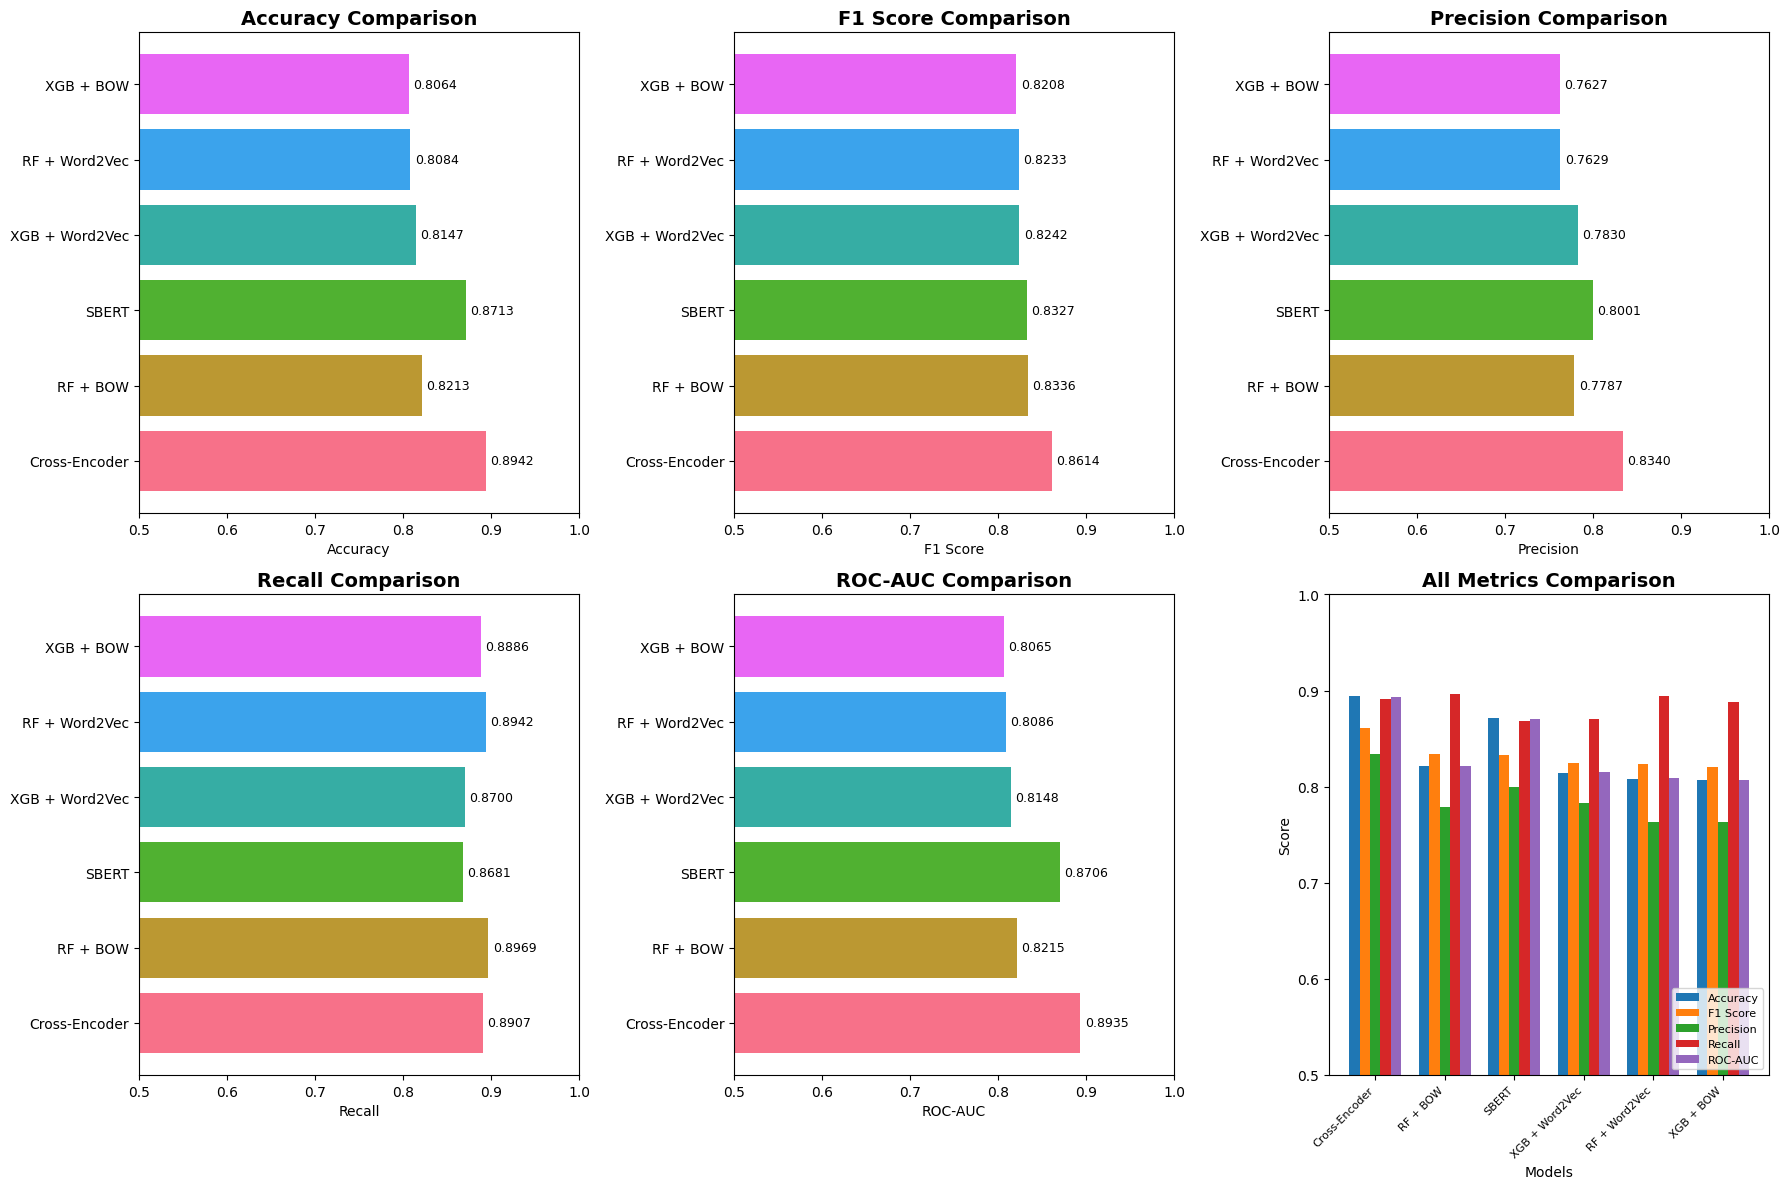


BEST MODEL: Cross-Encoder
   Accuracy:  0.8942
   F1 Score:  0.8614
   Precision: 0.8340
   Recall:    0.8907
   ROC-AUC:   0.8935


In [107]:
# ============================================
# VISUALIZE METRICS COMPARISON - BAR PLOTS
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

colors = sns.color_palette("husl", len(results_df))

# Accuracy comparison
ax1 = axes[0, 0]
bars = ax1.barh(results_df['Model'], results_df['Accuracy'], color=colors)
ax1.set_xlabel('Accuracy')
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim(0.5, 1)
for i, bar in enumerate(bars):
    ax1.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{results_df["Accuracy"].iloc[i]:.4f}', va='center', fontsize=9)

# F1 Score comparison
ax2 = axes[0, 1]
bars = ax2.barh(results_df['Model'], results_df['F1 Score'], color=colors)
ax2.set_xlabel('F1 Score')
ax2.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xlim(0.5, 1)
for i, bar in enumerate(bars):
    ax2.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{results_df["F1 Score"].iloc[i]:.4f}', va='center', fontsize=9)

# Precision comparison
ax3 = axes[0, 2]
bars = ax3.barh(results_df['Model'], results_df['Precision'], color=colors)
ax3.set_xlabel('Precision')
ax3.set_title('Precision Comparison', fontsize=14, fontweight='bold')
ax3.set_xlim(0.5, 1)
for i, bar in enumerate(bars):
    ax3.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{results_df["Precision"].iloc[i]:.4f}', va='center', fontsize=9)

# Recall comparison
ax4 = axes[1, 0]
bars = ax4.barh(results_df['Model'], results_df['Recall'], color=colors)
ax4.set_xlabel('Recall')
ax4.set_title('Recall Comparison', fontsize=14, fontweight='bold')
ax4.set_xlim(0.5, 1)
for i, bar in enumerate(bars):
    ax4.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{results_df["Recall"].iloc[i]:.4f}', va='center', fontsize=9)

# ROC-AUC comparison
ax5 = axes[1, 1]
bars = ax5.barh(results_df['Model'], results_df['ROC-AUC'], color=colors)
ax5.set_xlabel('ROC-AUC')
ax5.set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
ax5.set_xlim(0.5, 1)
for i, bar in enumerate(bars):
    ax5.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{results_df["ROC-AUC"].iloc[i]:.4f}', va='center', fontsize=9)

# Overall comparison (grouped bar chart)
ax6 = axes[1, 2]
x = np.arange(len(results_df))
width = 0.15
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC-AUC']
for i, metric in enumerate(metrics):
    ax6.bar(x + i*width, results_df[metric], width, label=metric)
ax6.set_xlabel('Models')
ax6.set_ylabel('Score')
ax6.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax6.set_xticks(x + width*2)
ax6.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=8)
ax6.legend(loc='lower right', fontsize=8)
ax6.set_ylim(0.5, 1)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Print best model
best_model = results_df.iloc[0]
print("\n" + "=" * 60)
print(f"BEST MODEL: {best_model['Model']}")
print("=" * 60)
print(f"   Accuracy:  {best_model['Accuracy']:.4f}")
print(f"   F1 Score:  {best_model['F1 Score']:.4f}")
print(f"   Precision: {best_model['Precision']:.4f}")
print(f"   Recall:    {best_model['Recall']:.4f}")
print(f"   ROC-AUC:   {best_model['ROC-AUC']:.4f}")

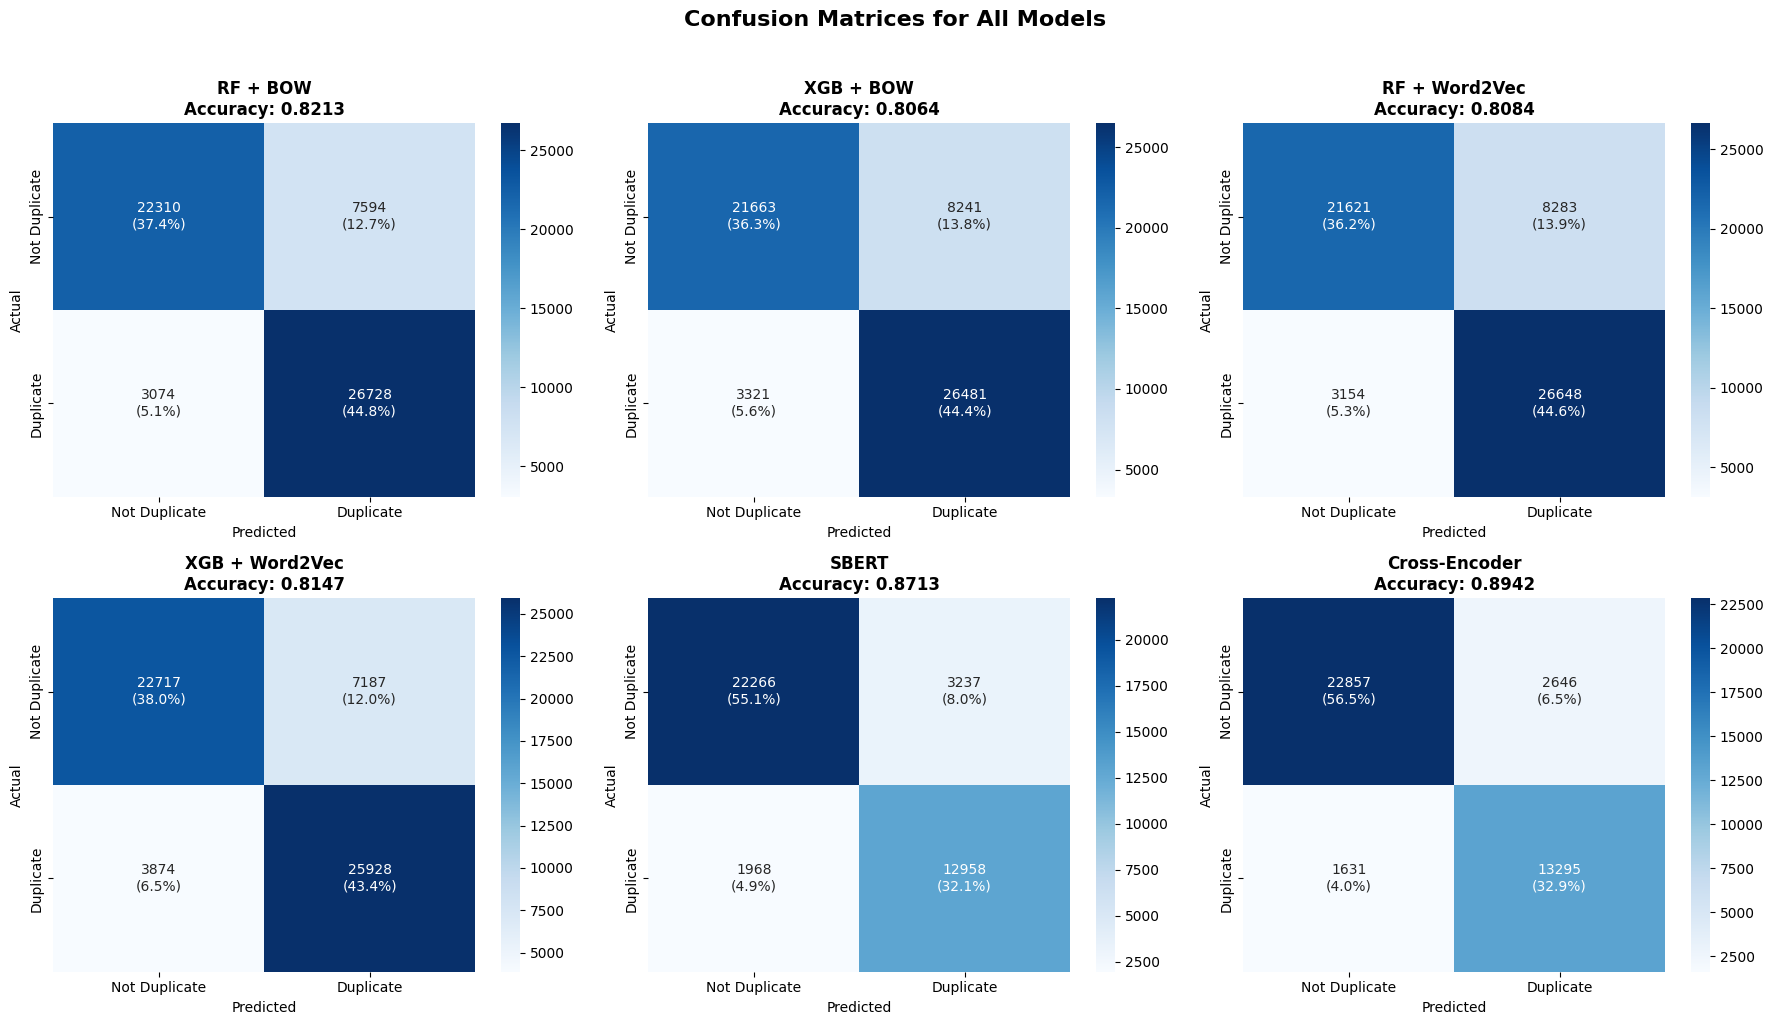

In [108]:
# ============================================
# CONFUSION MATRICES FOR ALL MODELS
# ============================================
n_models = len(predictions_dict)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten()

for idx, (name, data) in enumerate(predictions_dict.items()):
    cm = confusion_matrix(data['y_test'], data['y_pred'])
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum() * 100
    
    # Create annotations with both count and percentage
    annotations = np.array([[f'{val}\n({pct:.1f}%)' for val, pct in zip(row, pct_row)] 
                           for row, pct_row in zip(cm, cm_percent)])
    
    sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', ax=axes[idx],
                xticklabels=['Not Duplicate', 'Duplicate'],
                yticklabels=['Not Duplicate', 'Duplicate'],
                cbar=True)
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(data["y_test"], data["y_pred"]):.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Hide extra subplots
for idx in range(n_models, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

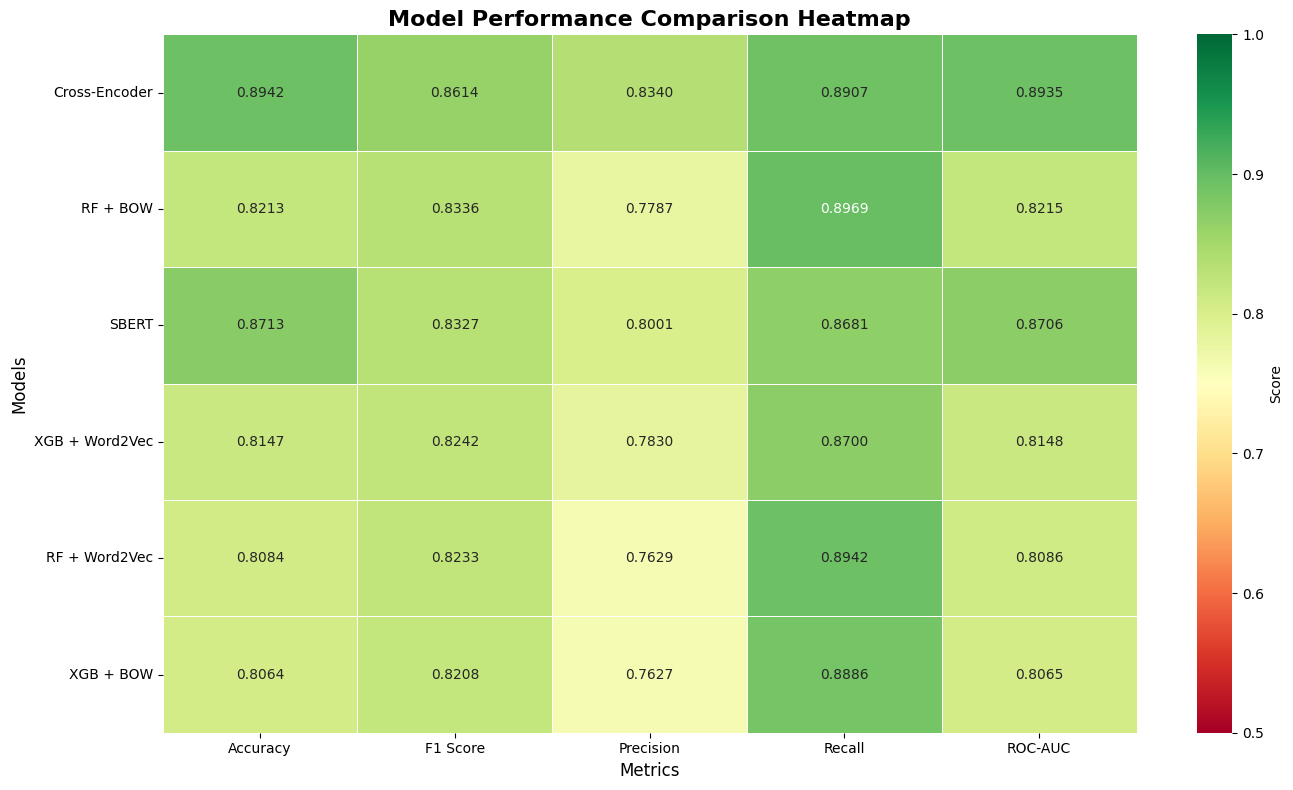


                         SUMMARY STATISTICS

Best Accuracy:  Cross-Encoder (0.8942)
Best F1 Score:  Cross-Encoder (0.8614)
Best Precision: Cross-Encoder (0.8340)
Best Recall:    RF + BOW (0.8969)
Best ROC-AUC:   Cross-Encoder (0.8935)


In [109]:
# ============================================
# HEATMAP - METRICS COMPARISON
# ============================================
plt.figure(figsize=(14, 8))

# Prepare data for heatmap
heatmap_data = results_df.set_index('Model')[['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC-AUC']]

# Create heatmap
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', fmt='.4f', 
            linewidths=0.5, vmin=0.5, vmax=1.0, cbar_kws={'label': 'Score'})
plt.title('Model Performance Comparison Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.tight_layout()
plt.savefig('model_comparison_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n" + "=" * 80)
print("                         SUMMARY STATISTICS")
print("=" * 80)
print(f"\nBest Accuracy:  {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']} ({results_df['Accuracy'].max():.4f})")
print(f"Best F1 Score:  {results_df.loc[results_df['F1 Score'].idxmax(), 'Model']} ({results_df['F1 Score'].max():.4f})")
print(f"Best Precision: {results_df.loc[results_df['Precision'].idxmax(), 'Model']} ({results_df['Precision'].max():.4f})")
print(f"Best Recall:    {results_df.loc[results_df['Recall'].idxmax(), 'Model']} ({results_df['Recall'].max():.4f})")
print(f"Best ROC-AUC:   {results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']} ({results_df['ROC-AUC'].max():.4f})")

In [110]:
# ============================================
# SAVE FINAL COMPARISON RESULTS
# ============================================
results_df.to_csv('model_comparison_results.csv', index=False)
print("Comparison results saved to model_comparison_results.csv")
print("\nAll saved artifacts:")
print("  - sbert_results.joblib          (SBERT scores, threshold, labels)")
print("  - sbert_predictions.joblib      (SBERT predicted labels)")
print("  - cross_encoder_results.joblib  (Cross-Encoder scores, threshold, labels)")
print("  - model_comparison_results.csv  (Comparison metrics table)")
print("  - model_comparison_metrics.png  (Bar chart visualization)")
print("  - confusion_matrices_all_models.png")
print("  - model_comparison_heatmap.png")

Comparison results saved to model_comparison_results.csv

All saved artifacts:
  - sbert_results.joblib          (SBERT scores, threshold, labels)
  - sbert_predictions.joblib      (SBERT predicted labels)
  - cross_encoder_results.joblib  (Cross-Encoder scores, threshold, labels)
  - model_comparison_results.csv  (Comparison metrics table)
  - model_comparison_metrics.png  (Bar chart visualization)
  - confusion_matrices_all_models.png
  - model_comparison_heatmap.png


# 🚀 Production Semantic Search Pipeline (SBERT + CrossEncoder + FAISS)

**Architecture:**
```
OFFLINE:  FAQ → SBERT Encode → FAISS Index (one time)
RUNTIME:  User Query → SBERT → Top K from FAISS → CrossEncoder Rerank → Best Answer
```

**Pre-requisites:** Run `dataset.ipynb` first to generate `dataset/faq_data.csv` from `single_qna.csv`.

In [ ]:
# ============================================================
# STEP 0 — Install Required Libraries
# ============================================================
%pip install faiss-cpu sentence-transformers joblib scipy --quiet

## 🏗 STEP 1 — OFFLINE PHASE (One-Time Indexing)
Encode all FAQ questions with SBERT, build FAISS index, save everything to disk.

In [ ]:
# ============================================================
# 1.1 — Load Trained SBERT Model
# ============================================================
from sentence_transformers import SentenceTransformer, CrossEncoder
import pandas as pd
import numpy as np
import faiss
import joblib
import os

# Load the fine-tuned SBERT bi-encoder (trained earlier in this notebook)
sbert_model = SentenceTransformer('./sbert_quora_model')

print(f"✅ SBERT model loaded from ./sbert_quora_model")
print(f"   Max sequence length: {sbert_model.max_seq_length}")
print(f"   Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")

In [ ]:
# ============================================================
# 1.2 — Load / Use CrossEncoder
# ============================================================
# The CrossEncoder was trained in cell 114 above and saved to ./cross_encoder_quora
# If running top-to-bottom, cross_model is already in memory.
# If running only this section, we load from disk or retrain.

cross_encoder_path = './cross_encoder_quora'

if 'cross_model' in dir() and cross_model is not None:
    print("✅ CrossEncoder already loaded in memory (from training above)")
    # Ensure it's also saved to disk for future runs
    if not os.path.exists(cross_encoder_path):
        cross_model.save(cross_encoder_path)
        print(f"   💾 Saved to {cross_encoder_path} for future use")
elif os.path.exists(cross_encoder_path):
    cross_model = CrossEncoder(cross_encoder_path)
    print(f"✅ CrossEncoder loaded from {cross_encoder_path}")
else:
    print(f"⚠️  CrossEncoder not found at {cross_encoder_path}")
    print("   Retraining CrossEncoder from scratch (this will take a while)...")
    
    from sentence_transformers import InputExample
    from torch.utils.data import DataLoader
    from sklearn.model_selection import train_test_split
    
    # Load training data
    df_ce = pd.read_csv("train.csv")
    df_ce = df_ce[['question1', 'question2', 'is_duplicate']].dropna()
    train_df_ce, _ = train_test_split(df_ce, test_size=0.1, stratify=df_ce['is_duplicate'], random_state=42)
    
    # Initialize fresh CrossEncoder
    cross_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', num_labels=1)
    
    # Prepare training data
    cross_train_examples = [
        InputExample(texts=[row['question1'], row['question2']], label=float(row['is_duplicate']))
        for _, row in train_df_ce.iterrows()
    ]
    cross_train_dataloader = DataLoader(cross_train_examples, shuffle=True, batch_size=16)
    
    # Train
    num_epochs_ce = 2
    warmup_steps_ce = int(len(cross_train_dataloader) * num_epochs_ce * 0.1)
    
    cross_model.fit(
        train_dataloader=cross_train_dataloader,
        epochs=num_epochs_ce,
        warmup_steps=warmup_steps_ce,
        output_path=cross_encoder_path,
        show_progress_bar=True
    )
    
    # Explicit save to guarantee persistence
    cross_model.save(cross_encoder_path)
    print(f"✅ CrossEncoder trained and saved to {cross_encoder_path}")

In [ ]:
# ============================================================
# 1.3 — Load the FAQ Dataset (created in dataset.ipynb)
# ============================================================

faq_df = pd.read_csv("dataset/faq_data.csv")
faq_df = faq_df.dropna()

faq_questions = faq_df["question"].tolist()
faq_answers = faq_df["answer"].tolist()

print(f"✅ Loaded {len(faq_questions)} FAQ pairs from dataset/faq_data.csv")
print(f"\nSample FAQ:")
for i in range(min(3, len(faq_questions))):
    print(f"\n  Q: {faq_questions[i][:100]}")
    print(f"  A: {faq_answers[i][:100]}")

In [ ]:
# ============================================================
# 1.4 — Generate SBERT Embeddings for All FAQ Questions
# ============================================================
# Embeddings are cached to disk — on re-run, they load instantly.

EMBEDDINGS_PATH = "faq_embeddings.npy"

if os.path.exists(EMBEDDINGS_PATH):
    faq_embeddings = np.load(EMBEDDINGS_PATH)
    print(f"✅ Loaded cached embeddings from {EMBEDDINGS_PATH}")
    print(f"   Shape: {faq_embeddings.shape}  |  Dtype: {faq_embeddings.dtype}")
else:
    print("Encoding FAQ questions with SBERT (this may take a few minutes)...")

    faq_embeddings = sbert_model.encode(
        faq_questions,
        convert_to_numpy=True,
        show_progress_bar=True,
        normalize_embeddings=True,   # enables cosine similarity via dot product
        batch_size=128
    )

    # Save to disk for future runs
    np.save(EMBEDDINGS_PATH, faq_embeddings)
    print(f"\n✅ Embeddings generated and saved to {EMBEDDINGS_PATH}")
    print(f"   Shape: {faq_embeddings.shape}  |  Dtype: {faq_embeddings.dtype}")

In [ ]:
# ============================================================
# 1.5 — Build or Load FAISS Index
# ============================================================

FAISS_INDEX_PATH = "faq_faiss.index"

if os.path.exists(FAISS_INDEX_PATH):
    index = faiss.read_index(FAISS_INDEX_PATH)
    print(f"✅ Loaded existing FAISS index from {FAISS_INDEX_PATH}")
    print(f"   Total indexed FAQs: {index.ntotal}")
else:
    dimension = faq_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(faq_embeddings)
    print(f"✅ FAISS index built from scratch!")
    print(f"   Dimension: {dimension}")
    print(f"   Total indexed FAQs: {index.ntotal}")

In [ ]:
# ============================================================
# 1.6 — Save FAISS Index + Metadata to Disk (if not already saved)
# ============================================================

FAISS_INDEX_PATH = "faq_faiss.index"
METADATA_PATH = "faq_metadata.joblib"

saved_any = False

if not os.path.exists(FAISS_INDEX_PATH):
    faiss.write_index(index, FAISS_INDEX_PATH)
    print(f"💾 Saved: {FAISS_INDEX_PATH}")
    saved_any = True
else:
    print(f"✅ Already exists: {FAISS_INDEX_PATH}")

if not os.path.exists(METADATA_PATH):
    joblib.dump({
        "questions": faq_questions,
        "answers": faq_answers
    }, METADATA_PATH)
    print(f"💾 Saved: {METADATA_PATH}")
    saved_any = True
else:
    print(f"✅ Already exists: {METADATA_PATH}")

if not saved_any:
    print("\n✅ All offline artifacts already on disk — nothing new to save.")
else:
    print("\n✅ Offline indexing complete!")

## ⚡ STEP 2 — RUNTIME PHASE (User Query Time)

This is what runs when a user asks a question:
1. Encode query with SBERT
2. FAISS retrieves Top K candidates
3. CrossEncoder re-ranks them
4. Return the best match

In [ ]:
# ============================================================
# 2.1 — Load Everything (for standalone runtime use)
# ============================================================
# If you already ran the offline phase above, these are already in memory.
# This cell is here so you can restart the kernel and run ONLY the runtime.

from sentence_transformers import SentenceTransformer, CrossEncoder
import faiss
import joblib
import numpy as np
import os

# Load SBERT (skip if already in memory)
if 'sbert_model' not in dir() or sbert_model is None:
    sbert_model = SentenceTransformer('./sbert_quora_model')
    print("✅ SBERT loaded from disk")
else:
    print("✅ SBERT already in memory")

# Load CrossEncoder (skip if already in memory)
cross_encoder_path = './cross_encoder_quora'
if 'cross_model' not in dir() or cross_model is None:
    if os.path.exists(cross_encoder_path):
        cross_model = CrossEncoder(cross_encoder_path)
        print(f"✅ CrossEncoder loaded from {cross_encoder_path}")
    else:
        print("⚠️  cross_encoder_quora dir not found and cross_model not in memory!")
        print("   Run the training section first (cells 112-114).")
else:
    print("✅ CrossEncoder already in memory")

# Load FAISS index (skip if already in memory)
if 'index' not in dir() or index is None:
    index = faiss.read_index("faq_faiss.index")
    print(f"✅ FAISS index loaded from disk ({index.ntotal} FAQs)")
else:
    print(f"✅ FAISS index already in memory ({index.ntotal} FAQs)")

# Load metadata (skip if already in memory)
if 'faq_questions' not in dir() or faq_questions is None:
    metadata = joblib.load("faq_metadata.joblib")
    faq_questions = metadata["questions"]
    faq_answers = metadata["answers"]
    print(f"✅ Metadata loaded from disk ({len(faq_questions)} FAQs)")
else:
    print(f"✅ Metadata already in memory ({len(faq_questions)} FAQs)")

print(f"\n🚀 Runtime ready — {index.ntotal} FAQs indexed")

In [ ]:
# ============================================================
# 2.2 — User Query → SBERT Encoding
# ============================================================

user_query = "Does this phone support fast charging?"

query_embedding = sbert_model.encode(
    user_query,
    convert_to_numpy=True,
    normalize_embeddings=True
).reshape(1, -1)

print(f"Query: '{user_query}'")
print(f"Embedding shape: {query_embedding.shape}")

In [ ]:
# ============================================================
# 2.3 — Retrieve Top 50 Candidates Using FAISS
# ============================================================

top_k = 50

scores, indices = index.search(query_embedding, top_k)

retrieved_questions = [faq_questions[i] for i in indices[0]]
retrieved_answers = [faq_answers[i] for i in indices[0]]

print(f"✅ Retrieved {len(retrieved_questions)} candidates from FAISS")
print(f"\nTop 5 FAISS matches (by SBERT cosine similarity):")
for i in range(min(5, len(retrieved_questions))):
    print(f"  [{i+1}] (score: {scores[0][i]:.4f}) {retrieved_questions[i][:80]}")

In [ ]:
# ============================================================
# 2.4 — Re-Rank Using Trained CrossEncoder
# ============================================================
from scipy.special import expit

# Create (query, candidate) pairs for CrossEncoder
pairs = [(user_query, q) for q in retrieved_questions]

# CrossEncoder scores each pair
cross_scores = cross_model.predict(pairs)

# Convert raw logits to probabilities using sigmoid
cross_probs = expit(cross_scores)

# Sort by highest confidence
sorted_indices = np.argsort(-cross_probs)

best_idx = sorted_indices[0]
best_question = retrieved_questions[best_idx]
best_answer = retrieved_answers[best_idx]
best_score = cross_probs[best_idx]

print(f"✅ CrossEncoder re-ranking complete!")
print(f"\nTop 5 after re-ranking:")
for rank, idx in enumerate(sorted_indices[:5]):
    print(f"  [{rank+1}] (conf: {cross_probs[idx]:.4f}) {retrieved_questions[idx][:80]}")

In [ ]:
# ============================================================
# 2.5 — Return Final Answer
# ============================================================

print("=" * 60)
print("🔥 BEST MATCH")
print("=" * 60)
print(f"\nYour Query:  {user_query}")
print(f"\nMatched FAQ: {best_question}")
print(f"\nAnswer:      {best_answer}")
print(f"\nConfidence:  {best_score:.4f}")
print("=" * 60)

if best_score < 0.5:
    print("\n⚠️  Low confidence — the answer may not be relevant.")
    print("   Consider rephrasing your question or adding more FAQs.")

## 🎯 COMPLETE PRODUCTION FUNCTION
Wraps everything into a single reusable function.

In [ ]:
# ============================================================
# Production Search Function
# ============================================================
from scipy.special import expit

def search_faq(query, top_k=50, confidence_threshold=0.5):
    """
    Semantic FAQ search using SBERT (retrieval) + CrossEncoder (re-ranking).
    
    Args:
        query: User's question string
        top_k: Number of candidates to retrieve from FAISS (default: 50)
        confidence_threshold: Minimum confidence to consider a match valid
    
    Returns:
        dict with best matching question, answer, confidence, and top results
    """
    # Step 1: Encode query with SBERT
    query_embedding = sbert_model.encode(
        query,
        convert_to_numpy=True,
        normalize_embeddings=True
    ).reshape(1, -1)
    
    # Step 2: Retrieve top-K from FAISS
    scores, indices = index.search(query_embedding, top_k)
    
    retrieved_questions = [faq_questions[i] for i in indices[0]]
    retrieved_answers = [faq_answers[i] for i in indices[0]]
    
    # Step 3: Re-rank with CrossEncoder
    pairs = [(query, q) for q in retrieved_questions]
    cross_scores = cross_model.predict(pairs)
    cross_probs = expit(cross_scores)
    
    # Step 4: Sort by confidence
    sorted_indices = np.argsort(-cross_probs)
    best_idx = sorted_indices[0]
    
    best_confidence = float(cross_probs[best_idx])
    
    # Build top-5 results
    top_results = []
    for rank, idx in enumerate(sorted_indices[:5]):
        top_results.append({
            "rank": rank + 1,
            "question": retrieved_questions[idx],
            "answer": retrieved_answers[idx],
            "confidence": float(cross_probs[idx])
        })
    
    result = {
        "query": query,
        "question": retrieved_questions[best_idx],
        "answer": retrieved_answers[best_idx],
        "confidence": best_confidence,
        "is_confident": best_confidence >= confidence_threshold,
        "top_results": top_results
    }
    
    return result

print("✅ search_faq() function defined and ready!")

## 🧪 Test the Search Pipeline

In [ ]:
# ============================================================
# Test 1 — Single Query
# ============================================================

result = search_faq("Does this phone support fast charging?")

print("=" * 60)
print(f"🔍 Query:      {result['query']}")
print(f"📌 Best Match: {result['question']}")
print(f"💬 Answer:     {result['answer']}")
print(f"📊 Confidence: {result['confidence']:.4f}")
print(f"✅ Confident:  {result['is_confident']}")
print("=" * 60)

In [ ]:
# ============================================================
# Test 2 — Multiple Queries with Top-5 Results
# ============================================================

test_queries = [
    "How to replace the garbage disposal?",
    "Does it come with a power cord?",
    "Is this product waterproof?",
    "What batteries does this use?",
    "Can I return this product?"
]

for query in test_queries:
    result = search_faq(query)
    
    print("\n" + "=" * 60)
    print(f"🔍 Query: {query}")
    print(f"📌 Best:  {result['question'][:70]}")
    print(f"💬 Ans:   {result['answer'][:100]}")
    print(f"📊 Conf:  {result['confidence']:.4f} {'✅' if result['is_confident'] else '⚠️ LOW'}")
    
    print(f"\n  Top 5 re-ranked results:")
    for r in result['top_results']:
        print(f"    [{r['rank']}] ({r['confidence']:.4f}) {r['question'][:60]}")

In [ ]:
# ============================================================
# Interactive Search — Try your own queries!
# ============================================================

while True:
    user_input = input("\n🔍 Enter your question (or 'quit' to exit): ")
    
    if user_input.lower().strip() in ['quit', 'exit', 'q', '']:
        print("Goodbye! 👋")
        break
    
    result = search_faq(user_input)
    
    print(f"\n📌 Best Match: {result['question']}")
    print(f"💬 Answer:     {result['answer']}")
    print(f"📊 Confidence: {result['confidence']:.4f}")
    
    if not result['is_confident']:
        print("⚠️  Low confidence — answer may not be accurate.")